<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Understanding the Dataset

In [3]:
#Installing required library
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [71]:
#Importing necesseray libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

import keras_tuner as kt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [47]:
# Load preprocessed data
df = pd.read_csv('/content/bitcoin_prices_preprocessed.csv', index_col='Date', parse_dates=True)

# Display the first few rows of the data
df.head()

,Open,High,Low,Close,Volume,Daily_Return,MA7,MA30
Date,,,,,,,,
2015-03-07,272.294006,277.854004,270.132996,276.260986,17825900,0.012973,273.689715,244.523235
2015-03-08,276.433014,277.858002,272.565002,274.354004,22067900,-0.006903,275.711430,246.259502
2015-03-09,274.812012,292.700989,273.893005,289.606995,59178200,0.055596,277.702427,248.321268
2015-03-10,289.862000,300.044006,289.743011,291.760010,67770800,0.007434,279.139287,250.599535
2015-03-11,291.524994,297.390991,290.507996,296.378998,33963900,0.015831,282.465999,253.141835


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3625 entries, 2015-03-07 to 2025-02-06
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3625 non-null   float64
 1   High          3625 non-null   float64
 2   Low           3625 non-null   float64
 3   Close         3625 non-null   float64
 4   Volume        3625 non-null   int64  
 5   Daily_Return  3625 non-null   float64
 6   MA7           3625 non-null   float64
 7   MA30          3625 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 254.9 KB


In [49]:
# Select only the 'Close' price
df_close = df[['Close']]  # This ensures only the 'Close' column is selected

In [50]:
df_close.head()

,Close
Date,
2015-03-07,276.260986
2015-03-08,274.354004
2015-03-09,289.606995
2015-03-10,291.760010
2015-03-11,296.378998


## Train Test Split

In [51]:
# Define the number of prediction days (e.g., 60 days for test set)
prediction_days = 60

# Training Data: All data except the last 'prediction_days'
df_train = df_close[:len(df_close) - prediction_days].values

# Test Data: The last 'prediction_days' (e.g., last 60 days)
df_test = df_close[len(df_close) - prediction_days:].values

In [52]:
df_train.shape

(3565, 1)

In [53]:
df_test.shape

(60, 1)

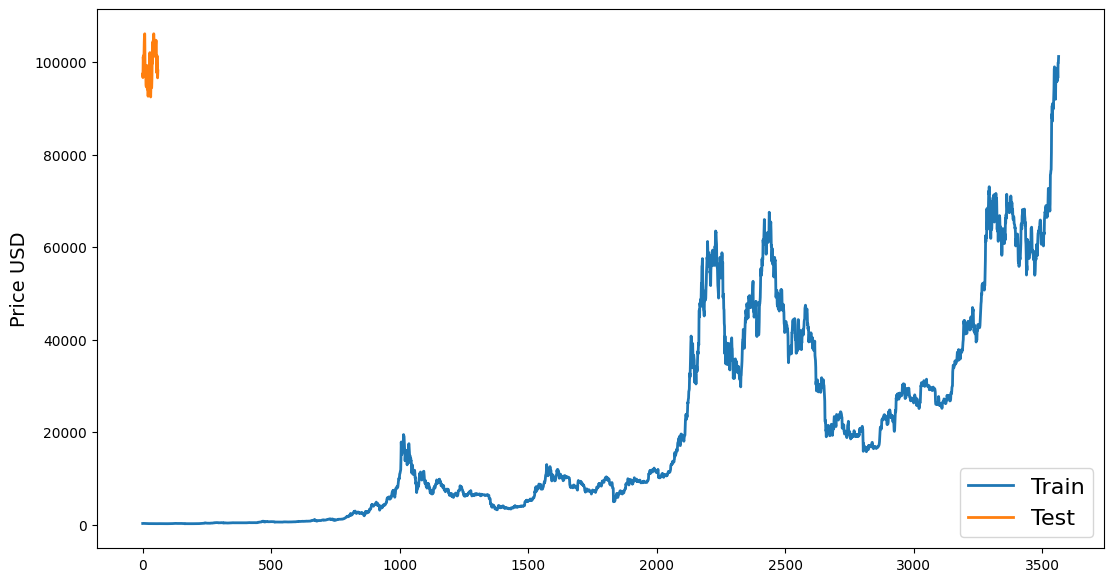

In [54]:
chosen_col = 'Close'

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

## 2. Data Preprocessing

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Min Max Scaling of Data post Train-Test Split </h3>
</div>



Scaling must be done after the data has been split into training and test sets — with each being scaled separately.

A common mistake when first using the LSTM is to first normalize the data before splitting the data.

The reason this is erroneous is that the normalization technique will use data from the test sets as a reference point when scaling the data as a whole. This will inadvertently influence the values of the training data, essentially resulting in data leakage from the test sets.


In [55]:
# Initialize the scaler for the training data
scaler_train = MinMaxScaler(feature_range=(0, 1))

# Rescale the training data
scaled_train = scaler_train.fit_transform(df_train.reshape(-1, 1))  # Reshape to (n_samples, 1) before scaling

# Initialize the scaler for the test data
scaler_test = MinMaxScaler(feature_range=(0, 1))

# Rescale the test data using the scaler fitted on the test set
scaled_test = scaler_test.fit_transform(df_test.reshape(-1, 1))  # Only transform test data

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Dataset Generator for LSTM </h3>
</div>



We will frame the problem to take a window of the last so many number of days of data to predict the current days data.

To achieve this, we will define a new function named `dataset_generator_lstm()` that will split the input sequence into windows of data appropriate for fitting a supervised learning model, like an LSTM


For example, if the sequence was:

1, 2, 3, 4, 5, 6, 7, 8, 9, 10


Then the samples for training the model will look like:

```

Input 				| Output
1, 2, 3, 4, 5 		6
2, 3, 4, 5, 6 		7
3, 4, 5, 6, 7 		8

```

LSTMs expect each sample in the dataset to have two dimensions; the first is the number of time steps (in the above case it is 5), and the second is the number of observations per time step (in this case it is 1).

Because it is a regression type problem, we will use a linear activation function in the output layer and optimize the mean squared error loss function. We will also evaluate the model using the mean squared error (MSE) metric.

## Define look_back period

A “lookback period” defines how many previous timesteps are used in order to predict the subsequent timestep.

For example if I set the lookback period is to 5, that that means that I am using the time steps at t-4, t-3, t-2, t-1, and t to predict the value at time t+1.

For my case below, I will be using a one-step prediction model.

### Lookback period


```py

lookback = 5

X_train, Y_train = dataset_generator_lstm(train, lookback)

X_val, Y_val = dataset_generator_lstm(val, lookback)

```

### Quick note on Python slice notation for slicing an array

- [1:5] is equivalent to "from 1 to 5" (5 not included)

- [1:] is equivalent to "1 to end"

- [len(a):] is equivalent to "from length of a to end"

In the below function I will generate the train_X array and train_y array for feeding into the LSTM

In [56]:
def dataset_generator_lstm(dataset, look_back=5):
    """
    Generates input-output pairs for an LSTM dataset.

    Args:
        dataset (numpy.ndarray): The dataset to generate input-output pairs from.
        look_back (int): The number of previous timesteps to use for prediction.

    Returns:
        numpy.ndarray: The input sequences.
        numpy.ndarray: The corresponding output values.
    """
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep.
    dataX, dataY = [], []

    # Iterate over the dataset, considering a "look_back" window of previous timesteps
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (3560, 5)
trainY:  (3560,)
testX:  (55, 5)
testY (55,)


In [57]:
print("trainX: ", trainX)

trainX:  [[6.50983938e-04 6.32107693e-04 7.83089253e-04 8.04400850e-04
  8.50121852e-04]
 [6.32107693e-04 7.83089253e-04 8.04400850e-04 8.50121852e-04
  8.30077472e-04]
 [7.83089253e-04 8.04400850e-04 8.50121852e-04 8.30077472e-04
  7.40822814e-04]
 ...
 [9.60839335e-01 9.46838077e-01 9.48192778e-01 9.75575633e-01
  9.54046806e-01]
 [9.46838077e-01 9.48192778e-01 9.75575633e-01 9.54046806e-01
  9.86980471e-01]
 [9.48192778e-01 9.75575633e-01 9.54046806e-01 9.86980471e-01
  9.87006455e-01]]


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> For LSTM I need to reshape input to be a 3D Tensor of [samples, time steps, features] </h3>
</div>

```py
X = numpy.reshape(dataX, (len(dataX), seq_length, 1))

```


**Samples** - This is the len(dataX), or the amount of data points you have.

**Time steps** - A sample contains multiple time steps, that is, the width of the sliding window (according to the above example, the time step is 3). Note here that it is distinguished from the sliding step of the sliding window. This is equivalent to the amount of time steps you run your recurrent neural network. If you want your network to have memory of 60 characters, this number should be 60. For this notebook, I am using the window-size to be 5.

**Features** - this is the amount of features in every time step. If you are processing pictures, this is the amount of pixels. In this case I have 1 feature (the price of Bitcoin) per time step.

 ### According to the documentation and the source code, the Keras LSTM input data must be in the form: [batch_size, timesteps, input_dim].

In [58]:
print(trainX.shape)
print(testX.shape)

(3560, 5)
(55, 5)


###  reshape trainX and testX

In [59]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (3560, 5, 1)
Shape of testX:  (55, 5, 1)


In [60]:
print("trainX: ", trainX)
print(" ********** ")
print("testX: ", testX)

trainX:  [[[6.50983938e-04]
  [6.32107693e-04]
  [7.83089253e-04]
  [8.04400850e-04]
  [8.50121852e-04]]

 [[6.32107693e-04]
  [7.83089253e-04]
  [8.04400850e-04]
  [8.50121852e-04]
  [8.30077472e-04]]

 [[7.83089253e-04]
  [8.04400850e-04]
  [8.50121852e-04]
  [8.30077472e-04]
  [7.40822814e-04]]

 ...

 [[9.60839335e-01]
  [9.46838077e-01]
  [9.48192778e-01]
  [9.75575633e-01]
  [9.54046806e-01]]

 [[9.46838077e-01]
  [9.48192778e-01]
  [9.75575633e-01]
  [9.54046806e-01]
  [9.86980471e-01]]

 [[9.48192778e-01]
  [9.75575633e-01]
  [9.54046806e-01]
  [9.86980471e-01]
  [9.87006455e-01]]]
 ********** 
testX:  [[[0.36221619]
  [0.30678679]
  [0.63598654]
  [0.55327445]
  [0.65693675]]

 [[0.30678679]
  [0.63598654]
  [0.55327445]
  [0.65693675]
  [0.65062087]]

 [[0.63598654]
  [0.55327445]
  [0.65693675]
  [0.65062087]
  [0.86476799]]

 [[0.55327445]
  [0.65693675]
  [0.65062087]
  [0.86476799]
  [0.99146941]]

 [[0.65693675]
  [0.65062087]
  [0.86476799]
  [0.99146941]
  [0.99958542]

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> LSTM (Long Short-Term Memory) Mechanism </h3>
</div>



The Long Short-Term Memory, or LSTM, is a recurrent neural network that is comprised of internal gates.

Unlike other recurrent neural networks, the network’s internal gates allow the model to be trained successfully using backpropagation through time, or BPTT, and avoid the vanishing gradients problem.

In the Keras deep learning library, LSTM layers can be created using the LSTM() class.

Creating a layer of LSTM memory units allows you to specify the number of memory units within the layer.

Each unit or cell within the layer has an internal cell state, often abbreviated as “c“, and outputs a hidden state, often abbreviated as “h“.

The Keras API allows you to access these data, which can be useful or even required when developing sophisticated recurrent neural network architectures, such as the encoder-decoder model.


## `input_shape` of LSTM Model - `input_shape` is supposed to be (timesteps, n_features).

    input_shape = (95000,360)

Keras LSTM takes and input with shape of (n_examples, n_times, n_features) and your layers input has to have this shape

## `return_sequences=True`

The original LSTM model is comprised of a single hidden LSTM layer followed by a standard feedforward output layer.

The Stacked LSTM is an extension to this model that has multiple hidden LSTM layers where each layer contains multiple memory cells.

You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer has a compatible n-dimensional sequence input.

#### To stack LSTM layers, we need to change the configuration of the prior LSTM layer to output a compatible n-dim array as input for the subsequent layer.

We can do this by setting the return_sequences argument on the layer to True (defaults to False). This will return one output for each input time step and provide the compatible n-dim array.

## Why Increase Depth of an LSTM ?

Stacking LSTM hidden layers makes the model deeper, more accurately earning the description as a deep learning technique.

It is the depth of neural networks that is generally attributed to the success of the approach on a wide range of challenging prediction problems.

Additional hidden layers can be added to a Multilayer Perceptron neural network to make it deeper. The additional hidden layers are understood to recombine the learned representation from prior layers and create new representations at high levels of abstraction. For example, from lines to shapes to objects.

A sufficiently large single hidden layer Multilayer Perceptron can be used to approximate most functions. Increasing the depth of the network provides an alternate solution that requires fewer neurons and trains faster. Ultimately, adding depth it is a type of representational optimization.

Given that LSTMs operate on sequence data, it means that the addition of layers adds levels of abstraction of input observations over time. In effect, chunking observations over time or representing the problem at different time scales.

Stacked LSTMs are now a stable technique for challenging sequence prediction problems.





In [61]:
# First checking the values for input_shape = (trainX.shape[1], trainX.shape[2])
# Note - `input_shape` of LSTM Model - `input_shape` is supposed to be (timesteps, n_features).

print("trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features) ", trainX.shape[1])
print("trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features) ", trainX.shape[2])

trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features)  5
trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features)  1


In [62]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# Set return_sequences=True when stacking LSTM layers so that the second LSTM layer
# has a compatible n-dimensional sequence input.

regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))


# Adding a third LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding a fourth LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Update the checkpoint path to use the .keras extension
checkpoint_path = 'my_best_model.keras'

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]  # Using both callbacks

# Train the model
history = regressor.fit(trainX, trainY, batch_size=32, epochs=60, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/60
108/112 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035
Epoch 1: val_loss improved from inf to 0.07208, saving model to my_best_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0041 - val_loss: 0.0721
Epoch 2/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0600
Epoch 2: val_loss improved from 0.07208 to 0.06984, saving model to my_best_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0597 - val_loss: 0.0698
Epoch 3/60
108/112 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0075
Epoch 3: val_loss improved from 0.06984 to 0.06881, saving model to my_best_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0074 - val_loss: 0.0688
Epoch 4/60
110/112 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022
Epoch 4: val_loss improved from 0.06881 to 0.06627, saving model to my_best_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0022 - val_loss: 0.0663
Epoch 5/60
109/112 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6130e-04
Epoc

## Plot line graph to show Loss Numbers relative to the epoch

In [65]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

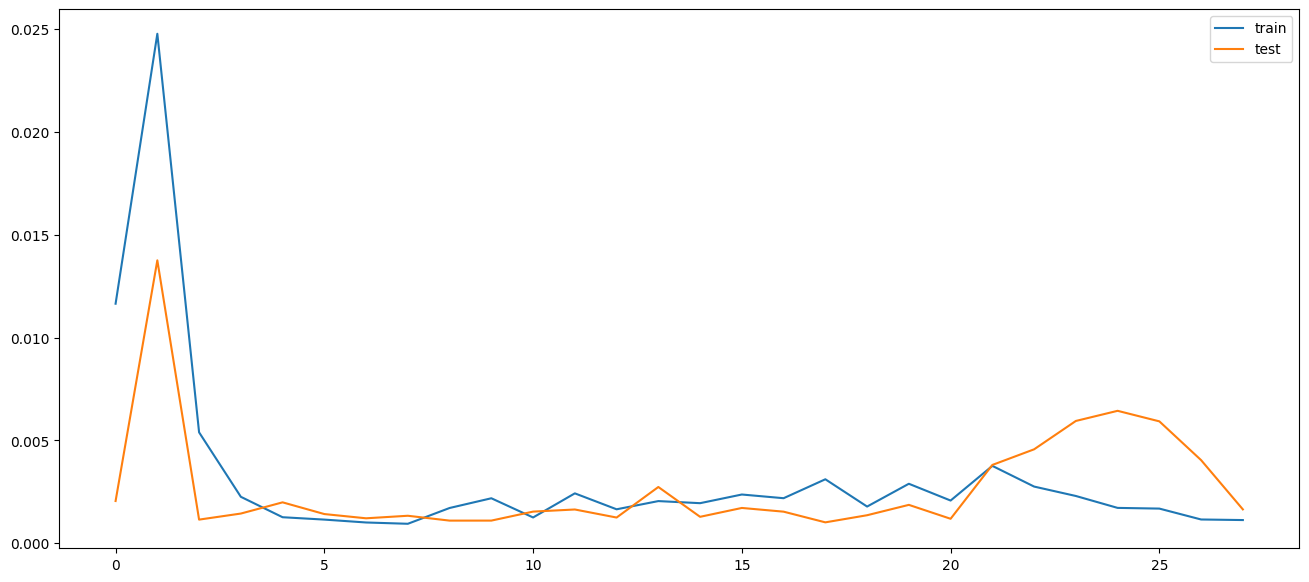

In [41]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> LSTM Predictions using testX and plotting line graph against Actual testY </h3>
</div>




Due to scaling step done earlier with MinMaxScaler the predicted scale is between 0 and 1.
Now, I need to transfer this scale to the original data scale (real value). for example:[0.58439621 0.58439621 0.58439621 ... 0.81262134 0.81262134 0.81262134], the pred answer transfer to :[250 100 50 60 .....]
So here I am going to use `inverse_transform` to Scale back the data to the original representation.

In [66]:
# Predicted data
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

# Inverse transform the predictions to the original scale
predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

# Inverse transform the actual test data to the original scale
test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 493ms/step


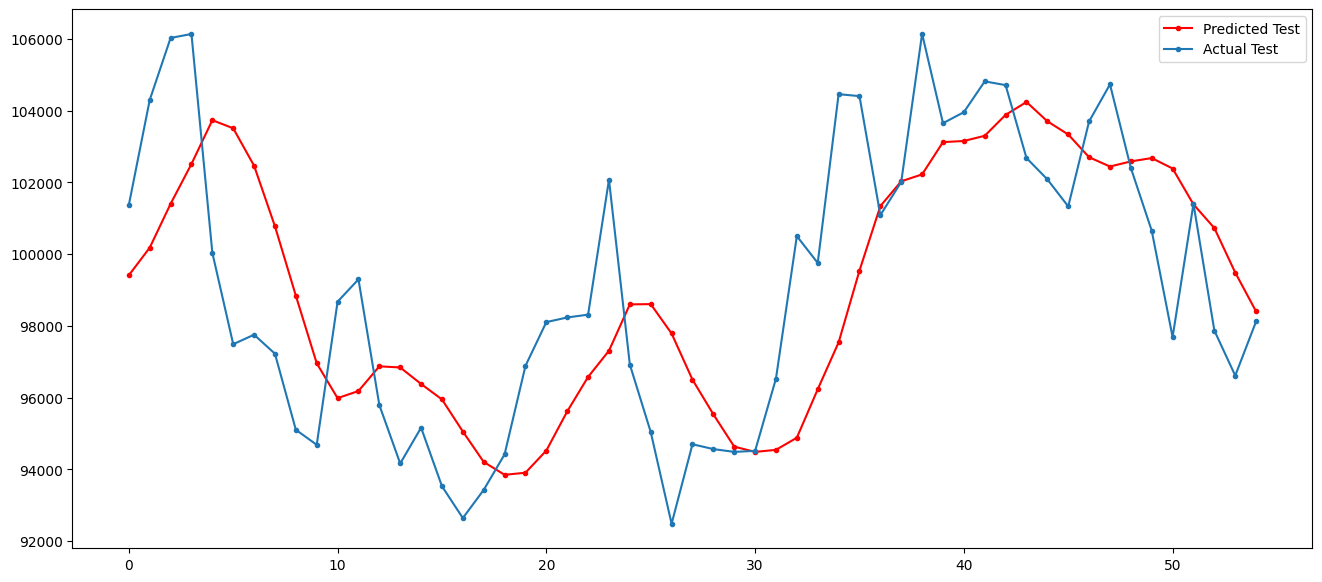

In [67]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

### LSTM Prediction using trainX and plotting line graph against Actual trainY

In [68]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


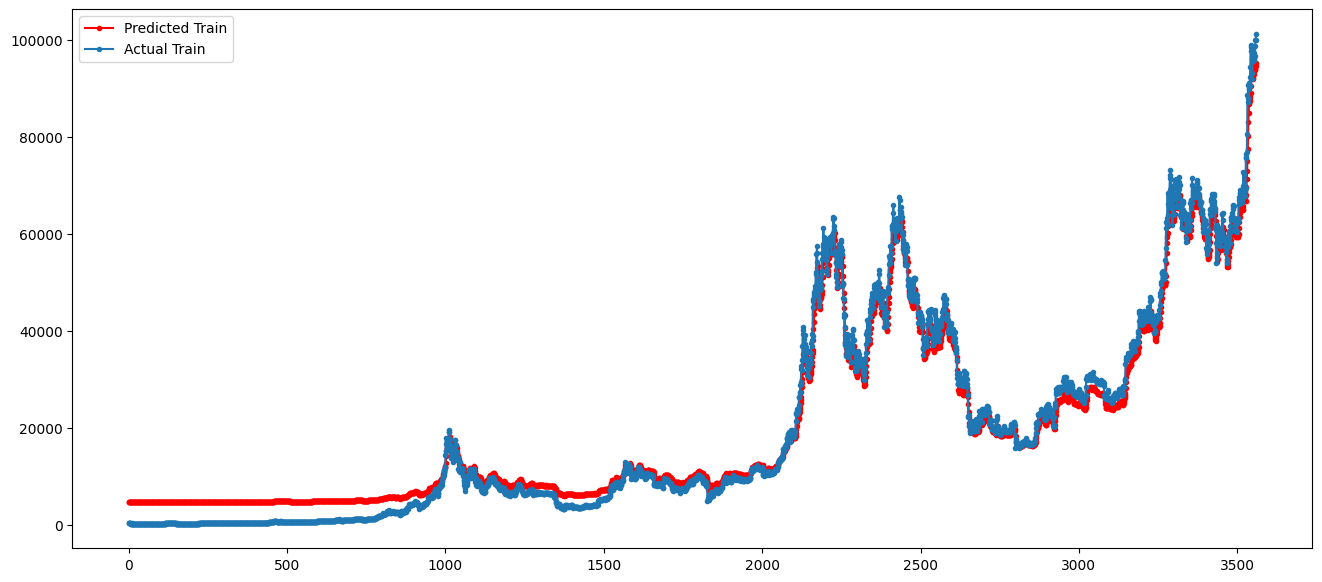

In [69]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

### RMSE - Test Data

In [72]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1666.162  => This seems best

Test RMSE: 3008.196


### RMSE - Train Data

In [73]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1047.916  => This seems best

Test RMSE: 2930.360


###  Future Price Predictions - For 5 Days beyond the actual trading

In [74]:
testX
testX.shape

(55, 5, 1)

In [75]:
lookback_period = 5

testX_last_5_days = testX[testX.shape[0] - lookback_period :  ]

testX_last_5_days.shape

(5, 5, 1)

In [76]:
testX_last_5_days

array([[[0.64765706],
        [0.82118181],
        [0.8967254 ],
        [0.72616161],
        [0.59813583]],

       [[0.82118181],
        [0.8967254 ],
        [0.72616161],
        [0.59813583],
        [0.38097286]],

       [[0.8967254 ],
        [0.72616161],
        [0.59813583],
        [0.38097286],
        [0.65299626]],

       [[0.72616161],
        [0.59813583],
        [0.38097286],
        [0.65299626],
        [0.39435602]],

       [[0.59813583],
        [0.38097286],
        [0.65299626],
        [0.39435602],
        [0.30239626]]])

In [77]:

predicted_5_days_forecast_price_test_x = []

for i in range(5):
  predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_5_days[i:i+1])

  predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  # print(predicted_forecast_price_test_x)
  predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

print("Forecast for the next 5 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x))
# That is the original Trading data ended on 30-Oct-2021, but now I am going to forecast beyond 30-Oct-2021

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Forecast for the next 5 Days Beyond the actual trading days  [[[102389.9  ]]

 [[101389.234]]

 [[100729.195]]

 [[ 99487.984]]

 [[ 98403.07 ]]]
